In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re 
import math

In [2]:
data_dir = '\\'.join([os.getcwd(), 'data'])
df = pd.read_csv('\\'.join([data_dir, 'hw3.csv']))

# Noticed parsing noise in token column. Extract string. 
print('Initial token column bar plot:')
# df.loc[:,'token'].value_counts().plot(kind = 'bar')

print('duplicates: ',df.duplicated().sum()) # check duplicates
df = df.drop_duplicates()

def extract(s):
    return re.findall(r'<span name="tokenName">(.*?)</span>', s)[0]

filt_nottoken = df.loc[:,'token'].apply(lambda x : len(x)>10)
df.loc[filt_nottoken,'token'] = df.loc[filt_nottoken,'token'].apply(lambda x : extract(x))

df.loc[:,'volumeUSD'] = df.loc[:,'volume'] * df.loc[:,'close'] # Fill in the values of volumeUSD
print('Without manipulation, volumeUSD has ', df.loc[:,'volumeUSD'].isnull().sum(), ' nans.', sep = '') # Check nans. 
print()
# print(df.loc[df.loc[:,'volumeUSD'].isnull()])
print('The potential reasons of obtaining null: ')
print('Column close has %d nans.' % (df.loc[:,'close'].isnull().sum()))
print('Column volumne has %d nans.' % (df.loc[:,'volume'].isnull().sum())) # So the reason is empty close. 
print()
# Close can be generated using high and low. Check high and low. 
print('Column high has %d nans.' % (df.loc[:,'high'].isnull().sum()))
print('Column low has %d nans.' % (df.loc[:,'low'].isnull().sum()))
print()
# Problems is close, not volume. 

# Both contains nans. Drop if both nan. 
df.dropna(axis = 0, subset = ['high', 'low'], how = 'all', inplace = True)

# If high and low both exist, fill in close as mean of high and low. 
filt_highandlow = df.loc[:,['high','low']].isnull().sum(axis = 1) == 0
filt_closenan = df.loc[:,'close'].isnull()
df.loc[filt_highandlow & filt_closenan, 'volumeUSD'] = df.loc[filt_highandlow & filt_closenan,['high','low']].mean(axis = 1)
df.sort_values(by = ['token','ts'], inplace = True)

# sorted by ts. Now want to foward fill, but want to avoid filling close with close of another token (edge case)
# Chose to do this with loop for safety. 

tokens = df.loc[:,'token'].unique()
for tok in tokens:
    df.loc[df.loc[:,'token'] == tok,'close'] = df.loc[df.loc[:,'token'] == tok].fillna(method = 'ffill')

df.loc[:,'volumeUSD'] = df.loc[:,'volume'] * df.loc[:,'close'] # Fill in the values of volumeUSD

# No nans now. Now deal with outliers. 

filt_outlier = (df.close / df.open >= 2) | (df.close / df.open <= 1/2)
print('number of outliers:', len(df.loc[filt_outlier]))
df.loc[filt_outlier, 'close'] = df.loc[filt_outlier, ['high','low']].mean(axis = 1)



Initial token column bar plot:
duplicates:  307
Without manipulation, volumeUSD has 116 nans.

The potential reasons of obtaining null: 
Column close has 116 nans.
Column volumne has 0 nans.

Column high has 450 nans.
Column low has 256 nans.

number of outliers: 56


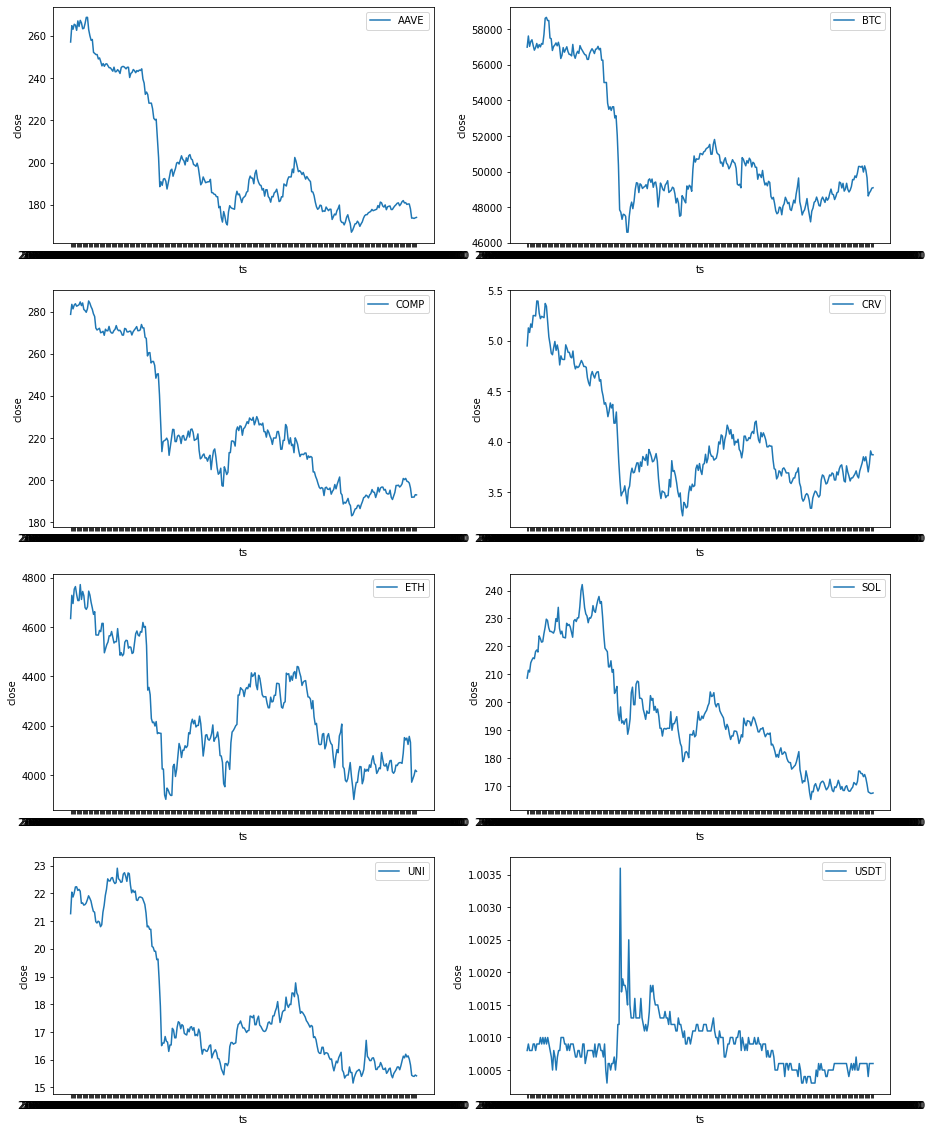

In [3]:
# This cell renders visualization. 
tokens_in_df = df.token.unique()

fig, axes = plt.subplots(nrows=math.ceil(tokens_in_df.size / 2), ncols=2, figsize=(15, 5 * math.ceil(tokens_in_df.size / 2)))

idx = 0
for label, df_token in df[['token','ts', 'close']].groupby('token'):
#     df_token['close'].plot(ax=axes[idx // 2, idx % 2], label=label)
    sns.lineplot(x = 'ts', y = 'close', data = df_token, ax=axes[idx // 2, idx % 2], label=label)
    axes[idx // 2, idx % 2].legend()
    
    idx += 1

In [4]:
# VolumeUSD by chain, aggregate as mean. If want sum 
df.loc[:,['chain','volumeUSD']].groupby('chain').sum()

,volumeUSD
chain,
BTC,3.767368e+10
ETH,1.712024e+10
SOL,6.848338e+09
USDT,1.495232e+09
